In [1]:
import matplotlib.pyplot as plt

rcParams_dict = {
    # ---------- figure
    'figure.figsize': [8, 6],
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    # ---------- axes
    'axes.grid': True,
    'axes.linewidth': 1.5,
    # ---------- ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.major.size': 8.0,
    'ytick.major.size': 8.0,
    # ---------- lines
    'lines.linewidth': 2.5,
    'lines.markersize': 12,
    # ---------- grid
    'grid.linestyle': ':',
    # ---------- font
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'cm',
    #'mathtext.fontset': 'stix',
    'font.size': 20,
    'axes.labelsize': 26,
    'legend.fontsize': 26,
    'svg.fonttype': 'path',  # Embed characters as paths
    #'svg.fonttype': 'none',  # Assume fonts are installed on the machine
    'pdf.fonttype': 42,  # embed fonts in PDF using type42 (True type)
}

plt.rcParams.update(rcParams_dict)

In [2]:

from ase.build import bulk
from ase.io import read
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor

t_atoms = read("NaCl.vasp")
nat = 8

#target atom energy
from chgnet.model import StructOptimizer
relaxer = StructOptimizer()
struc = AseAtomsAdaptor.get_structure(t_atoms)
result = relaxer.relax(atoms=struc, fmax=0.05, steps=1000)
# ---------- collect energy
t_energy = result['trajectory'].energies[-1]/nat

print(t_atoms)
print(t_energy)
view(t_atoms, viewer='x3d')


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
      Step     Time          Energy          fmax
FIRE:    0 16:44:36      -29.325579        0.123522
FIRE:    1 16:44:36      -29.326031        0.122266
FIRE:    2 16:44:37      -29.326923        0.119728
FIRE:    3 16:44:37      -29.328213        0.115889
FIRE:    4 16:44:37      -29.329857        0.110785
FIRE:    5 16:44:37      -29.331768        0.104500
FIRE:    6 16:44:37      -29.333872        0.096846
FIRE:    7 16:44:38      -29.336065        0.087235
FIRE:    8 16:44:38      -29.338436        0.073941
FIRE:    9 16:44:38      -29.340757        0.056526
FIRE:   10 16:44:38      -29.342615        0.031416
Atoms(symbols='Na4Cl4', pbc=True, cell=[5.6279997826, 5.6279997826, 5.6279997826])
-3.6678268909454346


In [3]:

from dscribe.descriptors import SOAP
import numpy as np
from cryspy.interactive import action
import pickle

path = './data/pkl_data/rslt_data.pkl'
with open(path, 'rb') as f:
    rslt_data = pickle.load(f)

species = ["Na","Cl"]
r_cut = 6.0
n_max = 4
l_max = 2

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    average="outer",
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

max_cid = 100
energy = []
snum=soap.get_number_of_features()
soap_array = np.empty((0,snum))
for cid in range(max_cid):
    atoms=action.get_atoms('opt', cid=cid)
    soap_atoms = soap.create(atoms)
    soap_array = np.append(soap_array, np.array([soap_atoms]), axis=0)
    energy.append(rslt_data.E_eV_atom[cid])
soap_atoms = soap.create(t_atoms)
soap_array = np.append(soap_array, np.array([soap_atoms]), axis=0)
energy.append(t_energy)

print(soap_array)
print(snum)
print(soap_array.shape)
print(len(energy))

[[ 4.90292869e-01 -2.01070719e+00  3.46875920e+00 ...  5.17104457e-01
   7.91226682e-01  1.89324757e+00]
 [ 8.47611907e-01 -3.22806816e+00  6.31871732e+00 ...  4.26087725e-02
  -8.39367428e-02  2.36051907e-01]
 [ 8.64812106e-01 -3.45959211e+00  6.03511254e+00 ...  5.47207269e-04
   2.10124869e-04  8.20322013e-05]
 ...
 [ 5.21975880e-01 -2.11033142e+00  3.62902042e+00 ...  1.20084263e+00
   5.44056368e-01  1.80269077e+00]
 [ 3.08422446e-01 -1.45389749e+00  1.67336730e+00 ...  7.65671997e-01
  -6.12427919e-01  1.05970981e+01]
 [ 9.23552193e-01 -3.60504382e+00  6.52725399e+00 ...  1.28075931e-30
  -7.84090186e-31  5.87139497e-31]]
108
(101, 108)
101


(101, 108)


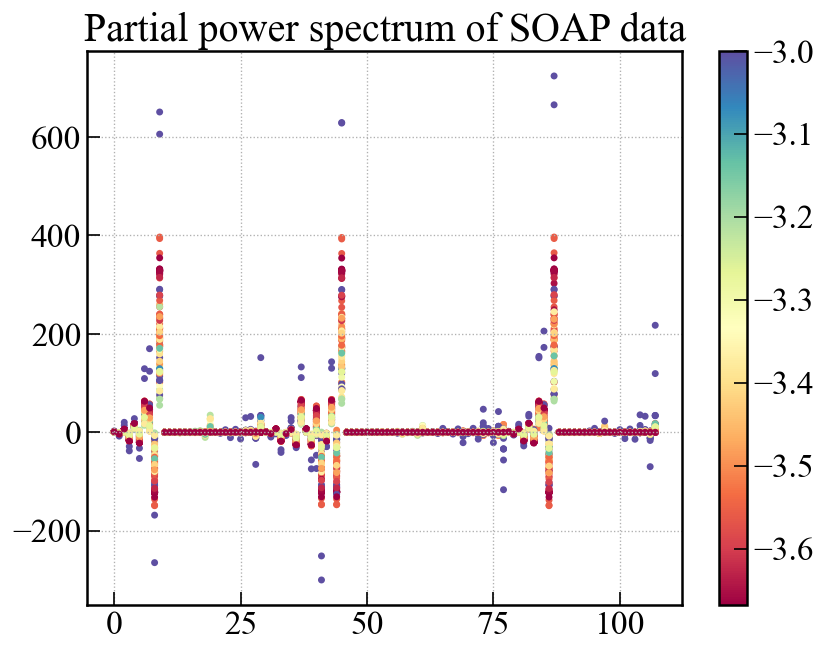

In [4]:

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# space_group_list=[]
# for cid in range(max_cid):
#     if not rslt_data.Spg_num[cid] in space_group_list:
#         space_group_list.append(rslt_data.Spg_num[cid])
# space_group_list = sorted(space_group_list)
# print(len(space_group_list))
# print(space_group_list)

#エネルギーのクリッピング
for cid in range (max_cid+1):
    energy[cid]=max(min(energy[cid],-3),-4)


x,y,c=[],[],[]
for cid in range(max_cid+1):
    x.append(range(snum))
    y.append(soap_array[cid])
    c.append([energy[cid]]*snum)
plt.scatter(x, y, c=c, cmap='Spectral', s=10)
# plt.colorbar(boundaries=np.arange(len(space_group_list)+1)-0.5).set_ticks(np.arange(len(space_group_list)))
# plt.colorbar(ticks=mticker.NullLocator())
plt.colorbar()
plt.title('Partial power spectrum of SOAP data')

print(soap_array.shape)

カラーバーの色が赤色に偏るため、エネルギーの上限を-3.0としてクリッピングしている

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(101, 2)


Text(0.5, 1.0, 'UMAP display of SOAP data')

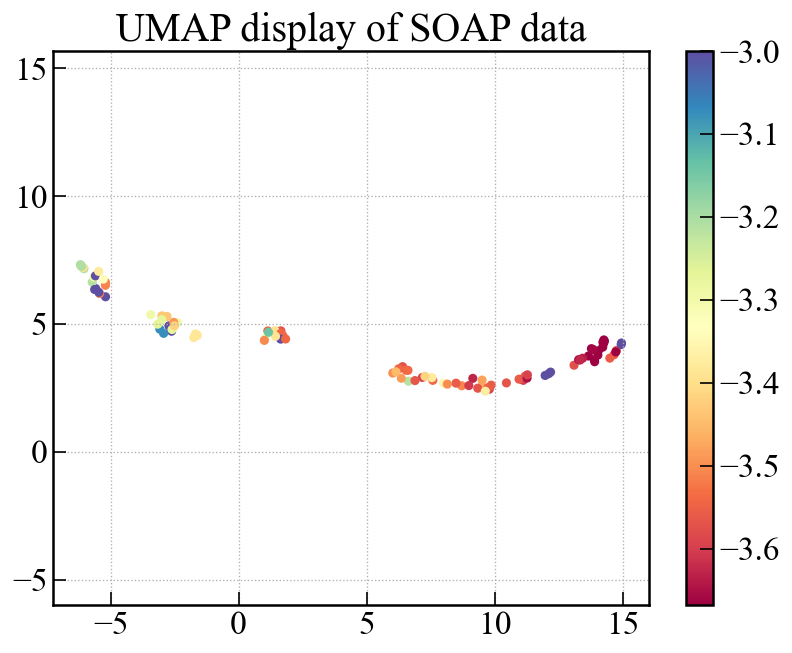

In [5]:
import umap

# umapで2次元に削減
reducer = umap.UMAP()
reducer.fit(soap_array)
embedding = reducer.transform(soap_array)
print(embedding.shape)

plt.scatter(embedding[:, 0], embedding[:, 1], c=energy, cmap='Spectral', s=20)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
# plt.colorbar(ticks=mticker.NullLocator())
plt.colorbar()
plt.title('UMAP display of SOAP data')
# データ分散が最も大きくなる向きに軸(第一主成分)をとり、第一主成分方向の大きさが横軸
# 縦軸は第一主成分と垂直に、データ分散が小さくなる向きに設定した第二主成分


energy  distance  cid  energy_difference
-3.668     0      100   0.00000
-3.562    21        1  -0.10558
-3.667    43        8  -0.00049
-3.667    44       74  -0.00038
-3.668    46       57   0.00000
-3.668    47       43   0.00011
-3.668    48       17   0.00015
-3.668    49       54   0.00015
-3.668    50       67   0.00015
-3.668    51        2   0.00012
理論構造とのユークリッド距離が最も近い構造


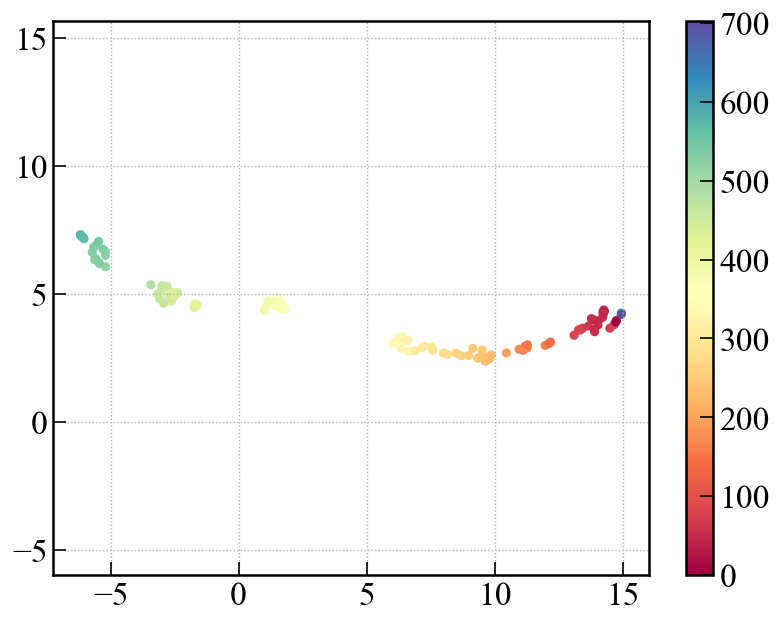

In [6]:
# ユークリッド距離計算
import numpy as np

tid=len(energy)-1 #target index

dist = []
non_sort_dist = []
min_dist = 9999999
for cid in range(max_cid+1):
    _dist = np.linalg.norm(soap_array[tid]-soap_array[cid])
    dist.append([_dist,cid])
    non_sort_dist.append(_dist)
    if min_dist>_dist and _dist>0:
        min_dist = _dist
dist=sorted(dist)

print("energy  distance  cid  energy_difference")
for i in range(10):
    print(f"{energy[dist[i][1]]:.3f} {dist[i][0]:>5.0f}      {dist[i][1]:>3}  {energy[tid]-energy[dist[i][1]]:>8.5f}")

_dist = []
for cid in range(max_cid+1):
    _dist.append(max(min_dist-100,non_sort_dist[cid]))
plt.scatter(embedding[:, 0], embedding[:, 1], c=_dist, cmap='Spectral', s=20)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()

print("理論構造とのユークリッド距離が最も近い構造")
view(action.get_atoms('opt', cid=dist[1][1]), viewer='x3d')

energy  distance   cid  energy_difference
-3.668  1.0000000  100   0.00000
-3.667  0.9999879    8  -0.00049
-3.667  0.9999871   74  -0.00038
-3.668  0.9999859   57   0.00000
-3.668  0.9999852   43   0.00011
-3.668  0.9999851   17   0.00015
-3.668  0.9999838   54   0.00015
-3.668  0.9999837   67   0.00015
-3.668  0.9999828    2   0.00012
-3.668  0.9999811   61   0.00013
理論構造とのコサイン距離が最も近い構造


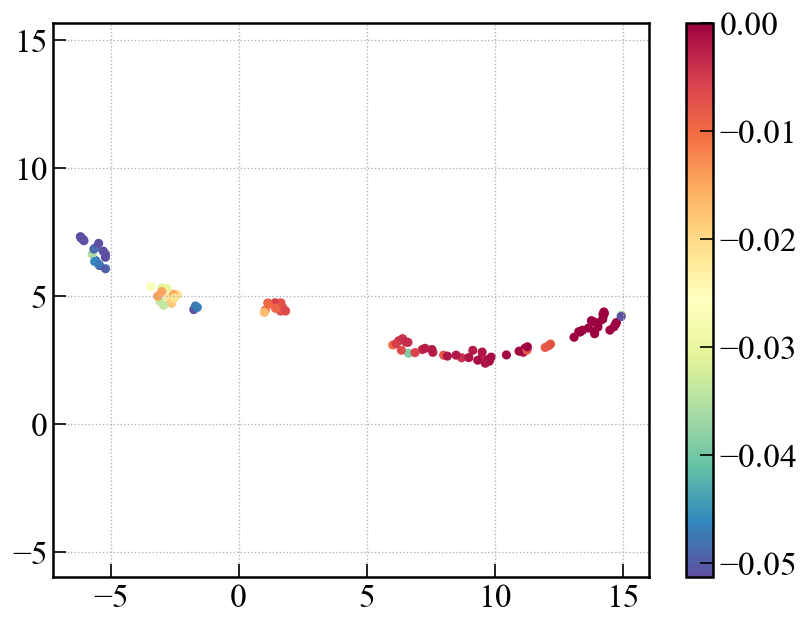

In [7]:
# コサイン距離計算
import math

def cos_sim(p, q):
    return np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

dist = []
non_sort_dist = []
min_dist = 9999999
for cid in range(max_cid+1):
    _dist = 1-cos_sim(soap_array[tid],soap_array[cid])
    dist.append([_dist,cid])
    non_sort_dist.append(_dist)
    if min_dist>_dist and _dist>0:
        min_dist = _dist
dist=sorted(dist)

print("energy  distance   cid  energy_difference")
for i in range(10):
    print(f"{energy[dist[i][1]]:.3f}  {1-dist[i][0]:>8.7f}  {dist[i][1]:>3}  {energy[tid]-energy[dist[i][1]]:>8.5f}")

_dist = []
for cid in range(max_cid+1):
    # _dist.append(max(math.log(1-non_sort_dist[cid]),-0.02))
    _dist.append(math.log(max(1-non_sort_dist[cid],0.95)))
plt.scatter(embedding[:, 0], embedding[:, 1], c=_dist, cmap='Spectral_r', s=20)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()

print("理論構造とのコサイン距離が最も近い構造")
view(action.get_atoms('opt', cid=dist[1][1]), viewer='x3d')

Text(0.5, 1.0, 'Partial power spectrum of SOAP data')

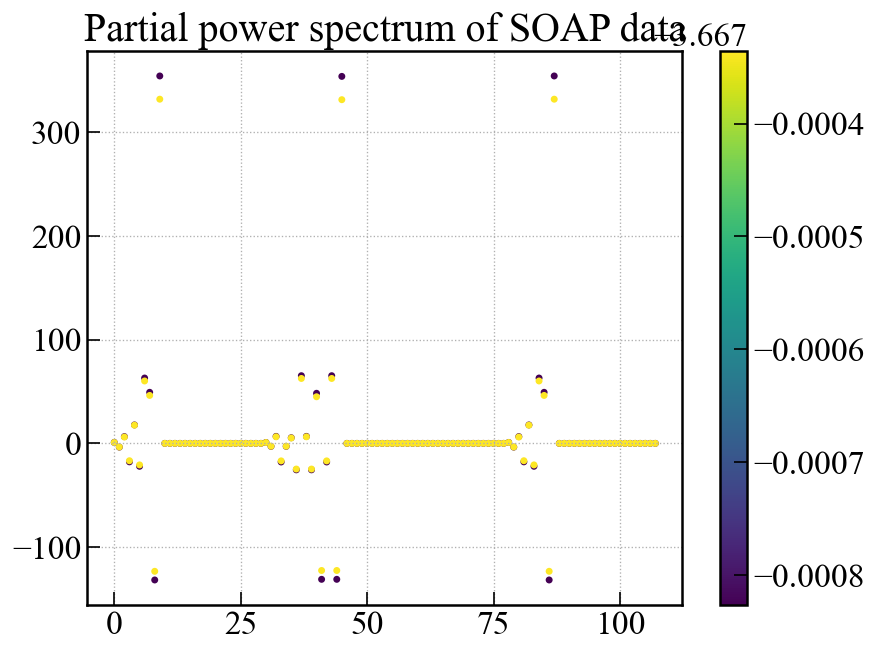

In [8]:
#2構造のSOAP比較
x,y,c=[],[],[]
for cid in [100,8]:
    x.append(range(snum))
    y.append(soap_array[cid])
    c.append([energy[cid]]*snum)
plt.scatter(x, y, c=c, s=10)
# plt.colorbar(boundaries=np.arange(len(space_group_list)+1)-0.5).set_ticks(np.arange(len(space_group_list)))
# plt.colorbar(ticks=mticker.NullLocator())
plt.colorbar()
plt.title('Partial power spectrum of SOAP data')
